In [1]:
import numpy as np
import matplotlib.pyplot as plt
from lib.envs import marketing
from lib.envs import tiger
from lib.envs import voicemail
from lib.envs import machinerepair
from lib.envs import cheezemaze
from lib.envs import fourbyfourmaze
import pyprind
import pdb

In [2]:
def softmax_action(env,memory_state,observation,θ_action):
    prob_list=np.exp(θ_action[memory_state,observation]) ##clipping the softmax function to prevent saturation
    den=np.sum(prob_list)
    prob=[prob_list[a]/den for a in range(θ_action.shape[2])]
    prob=prob/np.sum(prob)
    action_probs=prob.reshape(env.number_of_actions())
    #print(action_probs)
    action=np.random.multinomial(len(action_probs),action_probs).argmax()
    return action,action_probs

In [3]:
def softmax_transition(env,num_states,observation,memory_state,γ_transition):
    #import pdb;pdb.set_trace()
    prob_list=np.exp(γ_transition[observation,memory_state])
    den=np.sum(prob_list)
    prob=[prob_list[a]/den for a in range(γ_transition.shape[2])]
    prob=prob/np.sum(prob)
    transition_prob=prob.reshape(num_states)
    #print("Trainsition Prob",transition_prob)
    next_memory_state=np.random.multinomial(len(transition_prob),transition_prob).argmax()
    return next_memory_state,transition_prob
    


In [4]:
def grad_log_boltzman_policy(memory_state,observation,action,θ):
    res=np.zeros_like(θ)
    den=np.sum(np.exp(θ[memory_state,observation]))
    for j in range(θ.shape[2]):
        res[memory_state,observation,j]=-np.exp(θ[memory_state,observation,j])/den
    res[memory_state,observation,action]+=1.0
    
    return res
    

In [5]:
def grad_log_policy(env,memory_state,observation,action,θ):
    res=np.zeros_like(θ)
    left=1
    _,probs=softmax_action(env,memory_state,observation,θ)
    res[memory_state,observation,:]=left-probs
    return res

In [6]:
def grad_log_boltzman_transition(observation,memory_state,γ):
    res=np.zeros_like(γ)
    den=np.sum(np.exp(γ[observation,memory_state]))
    for j in range(γ.shape[2]):
        res[observation,memory_state,j]=-np.exp(γ[observation,memory_state,j])/den
    res[observation,memory_state,memory_state]+=1.0
    return res

In [7]:
def grad_log_transition(env,observation,memory_state,num_states,γ):
    res=np.zeros_like(γ)
    left=1
    _,probs=softmax_transition(env,num_states,observation,memory_state,γ)
    
    #pdb.set_trace()
    res[observation,memory_state,:]=left-probs
    
    return res

## Implementation of Istate-GPOMDP

In [8]:
env=tiger.TigerEnv()
#env=voicemail.VoicemailEnv()
#env=cheezemaze.CheeseMazeEnv()
num_states = 9 ##defines the number of controller states
# initial_observation_prob=np.array([0.5,0.5])
# observation=np.random.multinomial(len(initial_observation_prob),initial_observation_prob).argmax()
# memory_state=0
# z_θ=0
# z_ϕ=0
# Δ_θ=0
# Δ_ϕ=0
# β=0.95 ##For the tiger environment

In [9]:
iteration_reward=[]
θ=np.zeros(shape=(num_states,env.number_of_observations(),env.number_of_actions()))
γ=np.zeros(shape=(env.number_of_observations(), num_states,num_states))
iterations=1000
bar=pyprind.ProgBar(iterations)
memory_state=0
observation_probs=np.array([0.5,0.5])
observation=np.random.multinomial(len(observation_probs),observation_probs).argmax()
reward=0
for i in range(iterations):
    bar.update()
    
    z_θ=0
    z_ϕ=0
    Δ_θ=0
    Δ_ϕ=0
    β=0.95
    α=0.05
    #memory_state=0
    T=1000
    t=0
    #action=0
    #observation,reward,_=env.step(action)
    cum_rewards=0
    scale=1.0
    while t<T:
        
        next_memory_state,_=softmax_transition(env,num_states,observation,memory_state,γ)

        action,_=softmax_action(env,next_memory_state,observation,θ)

        z_ϕ=β*z_ϕ+grad_log_boltzman_transition(observation,memory_state,γ)

        z_θ=β*z_θ+grad_log_boltzman_policy(next_memory_state,observation,action,θ)

        ##alternative way
        #z_ϕ=β*z_ϕ+grad_log_transition(env,observation,memory_state,num_states,γ)

        #z_θ=β*z_θ+grad_log_policy(env,memory_state,observation,action,θ)

        
        
        Δ_θ=Δ_θ+(1/(t+1))*(reward*z_θ-Δ_θ)

        Δ_ϕ=Δ_ϕ+(1/(t+1)) * (reward*z_ϕ-Δ_ϕ)
        
        observation,reward,_=env.step(action)
        #print("Memory_State",memory_state)
        cum_rewards+=scale*reward
        scale*=β
        
        memory_state = next_memory_state
        
        t+=1
    iteration_reward.append(cum_rewards)
    #print("Iterations :",i)
    
    θ=θ+α*Δ_θ
    γ=γ+α*Δ_ϕ   
    θ=np.clip(θ,a_min=-30,a_max=30)
    γ=np.clip(γ,a_min=-30,a_max=30)   
print(bar)
    

0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:02:10


Title: 
  Started: 05/27/2018 01:49:03
  Finished: 05/27/2018 01:51:13
  Total time elapsed: 00:02:10


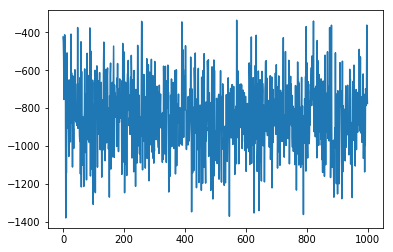

In [10]:
plt.plot(iteration_reward)

In [11]:

θ.shape

(9, 2, 3)